# Import 

In [1]:
import time
import math, json, os, sys
import matplotlib.pyplot as plt
import keras
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
import pandas as pd
import tensorflow as tf

2024-05-17 20:15:32.471326: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 20:15:32.650472: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-17 20:15:33.579438: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-17 20:15:38.562228: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Data processing 

## Split data  
(Use only one and use this for all other model)  

In [2]:
import os
import shutil
import random

def split_data(SOURCE, TRAINING, VALIDATION, TESTING, SPLIT_SIZE):
    all_files = os.listdir(SOURCE)
    n_files = len(all_files)
    random.shuffle(all_files)
    
    train_size = int(n_files * SPLIT_SIZE[0])
    valid_size = int(n_files * SPLIT_SIZE[1])
    
    train_files = all_files[:train_size]
    valid_files = all_files[train_size:train_size+valid_size]
    test_files = all_files[train_size+valid_size:]
    
    for file_name in train_files:
        source_file = os.path.join(SOURCE, file_name)
        dest_file = os.path.join(TRAINING, file_name)
        shutil.copyfile(source_file, dest_file)
    
    for file_name in valid_files:
        source_file = os.path.join(SOURCE, file_name)
        dest_file = os.path.join(VALIDATION, file_name)
        shutil.copyfile(source_file, dest_file)
    
    for file_name in test_files:
        source_file = os.path.join(SOURCE, file_name)
        dest_file = os.path.join(TESTING, file_name)
        shutil.copyfile(source_file, dest_file)

# Define paths
BASE_DIR = '160'
CLASSES = ['Abnormal', 'Normal']
SPLIT_SIZE = [0.4, 0.4, 0.2]

for class_name in CLASSES:
    SOURCE_DIR = os.path.join(BASE_DIR, class_name)
    TRAINING_DIR = os.path.join(BASE_DIR, 'train', class_name)
    VALIDATION_DIR = os.path.join(BASE_DIR, 'valid', class_name)
    TESTING_DIR = os.path.join(BASE_DIR, 'test', class_name)
    
    os.makedirs(TRAINING_DIR, exist_ok=True)
    os.makedirs(VALIDATION_DIR, exist_ok=True)
    os.makedirs(TESTING_DIR, exist_ok=True)
    
    split_data(SOURCE_DIR, TRAINING_DIR, VALIDATION_DIR, TESTING_DIR, SPLIT_SIZE)

## Get data

In [4]:
DATA_DIR = '160/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
VALID_DIR = os.path.join(DATA_DIR, 'val')
TARGET_SIZE = (64, 64)
BATCH_SIZE = 256

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data generators
train_datagen = ImageDataGenerator(rescale=1/255.0)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

train_generator = train_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'train'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

valid_generator = valid_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'valid'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_directory(
    os.path.join(DATA_DIR, 'test'),
    target_size=TARGET_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 13313 images belonging to 2 classes.
Found 13313 images belonging to 2 classes.
Found 6658 images belonging to 2 classes.


In [6]:
# Display information
print("Class Indices: ", train_generator.class_indices)

print(f"Number of training samples: {train_generator.samples}")
print(f"Number of validation samples: {valid_generator.samples}")
print(f"Number of test samples: {test_generator.samples}")

print("Training set:")
for class_name, idx in train_generator.class_indices.items():
    num_files = len(os.listdir(os.path.join(BASE_DIR, 'train', class_name)))
    print(f"{class_name} ({idx}): {num_files} files")

print("Validation set:")
for class_name, idx in valid_generator.class_indices.items():
    num_files = len(os.listdir(os.path.join(BASE_DIR, 'valid', class_name)))
    print(f"{class_name} ({idx}): {num_files} files")

print("Test set:")
for class_name, idx in test_generator.class_indices.items():
    num_files = len(os.listdir(os.path.join(BASE_DIR, 'test', class_name)))
    print(f"{class_name} ({idx}): {num_files} files")


Class Indices:  {'Abnormal': 0, 'Normal': 1}
Number of training samples: 13313
Number of validation samples: 13313
Number of test samples: 6658
Training set:
Abnormal (0): 5249 files
Normal (1): 8064 files
Validation set:
Abnormal (0): 5249 files
Normal (1): 8064 files
Test set:
Abnormal (0): 2626 files
Normal (1): 4032 files


# Save & visualize history of training

In [7]:
import pandas as pd


def save_history(history):
    acc = pd.Series(history.history["accuracy"], name="accuracy")
    loss = pd.Series(history.history["loss"], name="loss")
    val_acc = pd.Series(history.history["val_accuracy"], name="val_accuracy")
    val_loss = pd.Series(history.history["val_loss"], name="val_loss")
    com = pd.concat([acc, loss, val_acc, val_loss], axis=1)
    com.to_csv("history.csv", index=False)


import matplotlib.pyplot as plt


def plot_history(history):
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model Accuracy and Loss")
    plt.ylabel("Accuracy/Loss")
    plt.xlabel("Epoch")
    plt.legend(["accuracy", "val_accuracy", "loss", "val_loss"], loc="upper right")
    plt.show()
    plt.savefig("model_accuracy_loss.png")

# Train model

In [ ]:
start = time.process_time()
# num_train_steps = math.floor(13313 / BATCH_SIZE)
# num_valid_steps = math.floor(13313 / BATCH_SIZE)
num_train_steps = 13313 // BATCH_SIZE
num_valid_steps = 13313 // BATCH_SIZE
classes = list(iter(train_generator.class_indices))
Inp = Input((64, 64, 3))
base_model = keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=False, input_shape=(64, 64, 3)
)
x = base_model(Inp)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation="relu")(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation="softmax")(x)
finetuned_model = Model(inputs=Inp, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.5)
finetuned_model.compile(
    optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"]
)
for c in train_generator.class_indices:
    classes[train_generator.class_indices[c]] = c
finetuned_model.classes = classes
early_stopping = EarlyStopping(patience=15)
checkpointer = ModelCheckpoint(
    "resnet50_best.keras",
    verbose=1,
    save_best_only=True,
)
History = finetuned_model.fit(
    train_generator,
    steps_per_epoch=num_train_steps,
    epochs=15,
    callbacks=[early_stopping, checkpointer],
    validation_data=valid_generator,
    validation_steps=num_valid_steps,
)
save_history(History)
plot_history(History)
end2 = time.process_time()
print("final is in ", end2 - start)

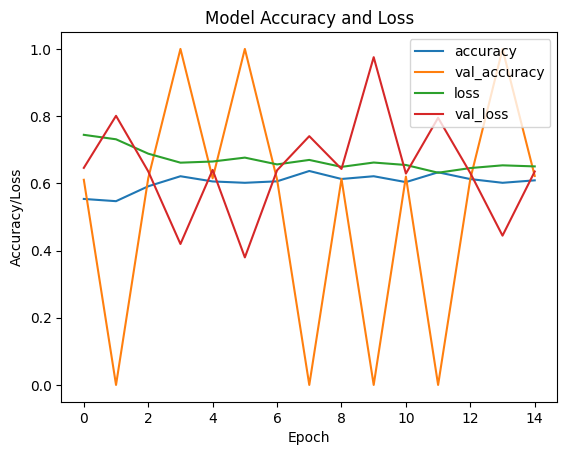

<Figure size 640x480 with 0 Axes>

In [15]:
save_history(History)
plot_history(History)

In [8]:
num_train_steps = 13313 // BATCH_SIZE
num_valid_steps = 13313 // BATCH_SIZE

In [11]:
classes = list(iter(train_generator.class_indices))
Inp = Input((64, 64, 3))
base_model = keras.applications.resnet50.ResNet50(
    weights="imagenet", include_top=False, input_shape=(64, 64, 3)
)
x = base_model(Inp)
x = Flatten(name="flatten")(x)
x = Dense(1024, activation="relu")(x) 
x = Dropout(0.5)(x)
predictions = Dense(len(classes), activation="softmax")(x)
finetuned_model = Model(inputs=Inp, outputs=predictions)
for layer in base_model.layers:
    layer.trainable = False
# sgd = SGD(lr=0.0001, decay=1e-6, momentum=0.5)
# Load the previously saved weights
finetuned_model.load_weights('/mnt/DataK/Project/GasHisCancer/PatchLevel_GasHisSDB/resnet50_best.keras')

finetuned_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 64, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2, 2, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     8,389,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │         2,050 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,979,394 (121.99 MB)

 Trainable params: 8,391,682 (32.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
# finetuned_model.compile(
#     optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"]
# )
# for c in train_generator.class_indices:
#     classes[train_generator.class_indices[c]] = c
# finetuned_model.classes = classes
# early_stopping = EarlyStopping(patience=15)
# checkpointer = ModelCheckpoint(
#     "resnet50_best.keras",
#     verbose=1,
#     save_best_only=True,
# )
History = finetuned_model.fit(
    train_generator,
    steps_per_epoch=num_train_steps,
    epochs=15,
    callbacks=[early_stopping, checkpointer],
    validation_data=valid_generator,
    validation_steps=num_valid_steps,
)
save_history(History)
plot_history(History)
# end2 = time.process_time()
# print("final is in ", end2 - start)

Epoch 1/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6253 - loss: 0.6240
Epoch 1: val_loss did not improve from 0.19141
52/52 ━━━━━━━━━━━━━━━━━━━━ 360s 7s/step - accuracy: 0.6252 - loss: 0.6240 - val_accuracy: 0.6263 - val_loss: 0.6181
Epoch 2/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3:16 4s/step - accuracy: 0.5938 - loss: 0.6582
Epoch 2: val_loss did not improve from 0.19141
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5938 - loss: 0.6582 - val_accuracy: 1.0000 - val_loss: 0.6154
Epoch 3/15


2024-05-17 22:57:20.645998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 22:57:20.701443: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6220 - loss: 0.6250
Epoch 3: val_loss did not improve from 0.19141
52/52 ━━━━━━━━━━━━━━━━━━━━ 417s 8s/step - accuracy: 0.6221 - loss: 0.6250 - val_accuracy: 0.6270 - val_loss: 0.6177
Epoch 4/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 3:14 4s/step - accuracy: 0.5664 - loss: 0.6603
Epoch 4: val_loss improved from 0.19141 to 0.15996, saving model to resnet50_best.keras


2024-05-17 23:04:21.608691: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 23:04:21.686244: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - accuracy: 0.5664 - loss: 0.6603 - val_accuracy: 1.0000 - val_loss: 0.1600
Epoch 5/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6183 - loss: 0.6259
Epoch 5: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 338s 6s/step - accuracy: 0.6184 - loss: 0.6258 - val_accuracy: 0.6265 - val_loss: 0.6193
Epoch 6/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 2:59 4s/step - accuracy: 0.6289 - loss: 0.6400
Epoch 6: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6289 - loss: 0.6400 - val_accuracy: 0.0000e+00 - val_loss: 0.9602
Epoch 7/15


2024-05-17 23:10:07.899739: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 23:10:07.955162: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6218 - loss: 0.6302
Epoch 7: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 340s 7s/step - accuracy: 0.6218 - loss: 0.6301 - val_accuracy: 0.6252 - val_loss: 0.6192
Epoch 8/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 2:17 3s/step - accuracy: 0.5859 - loss: 0.6328
Epoch 8: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5859 - loss: 0.6328 - val_accuracy: 0.0000e+00 - val_loss: 1.0565
Epoch 9/15


2024-05-17 23:15:51.002049: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 23:15:51.040606: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6220 - loss: 0.6248
Epoch 9: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 349s 7s/step - accuracy: 0.6221 - loss: 0.6247 - val_accuracy: 0.6252 - val_loss: 0.6192
Epoch 10/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 2:27 3s/step - accuracy: 0.6445 - loss: 0.6267
Epoch 10: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.6445 - loss: 0.6267 - val_accuracy: 1.0000 - val_loss: 0.5539
Epoch 11/15


2024-05-17 23:21:42.765100: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 23:21:42.808425: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6271 - loss: 0.6251
Epoch 11: val_loss did not improve from 0.15996
52/52 ━━━━━━━━━━━━━━━━━━━━ 304s 6s/step - accuracy: 0.6271 - loss: 0.6251 - val_accuracy: 0.6188 - val_loss: 0.6222
Epoch 12/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 2:37 3s/step - accuracy: 0.6055 - loss: 0.6169
Epoch 12: val_loss improved from 0.15996 to 0.15206, saving model to resnet50_best.keras


2024-05-17 23:26:50.068647: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 23:26:50.133486: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - accuracy: 0.6055 - loss: 0.6169 - val_accuracy: 1.0000 - val_loss: 0.1521
Epoch 13/15
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6222 - loss: 0.6248
Epoch 13: val_loss did not improve from 0.15206
52/52 ━━━━━━━━━━━━━━━━━━━━ 348s 7s/step - accuracy: 0.6223 - loss: 0.6247 - val_accuracy: 0.6301 - val_loss: 0.6168
Epoch 14/15
 1/52 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - accuracy: 1.0000 - loss: 0.1608
Epoch 14: val_loss did not improve from 0.15206
52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 1.0000 - loss: 0.1608 - val_accuracy: 0.0000e+00 - val_loss: 0.9520
Epoch 15/15


2024-05-17 23:32:41.532546: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-05-17 23:32:41.584766: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.6232 - loss: 0.6260

Lần thứ 4 rồi (60 lần epoch)